### 1. 환경 준비하기

#### 1. 패키지 설치하기

In [ ]:
!pip install torchio # DICOM/NIFTI 파일을 파이토치에서 활용하기 쉽게 도와줌
!pip install monai # 파이토치 기반의 의료영상 모델 학습을 쉽게 도와줌

     |████████████████████████████████| 160 kB 4.3 MB/s 
     |████████████████████████████████| 48.4 MB 10 kB/s 
     |████████████████████████████████| 650 kB 2.8 MB/s 


#### 2. 패키지 불러오기

In [ ]:
import os
import torch
import torchio as tio
import monai
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from shutil import copyfile
from sklearn.model_selection import train_test_split

##### 1. 패키지 버전 확인하기

In [ ]:
print('패키지 버전')
print(f'torch: {torch.__version__}')
print(f'torchio: {tio.__version__}')
print(f'monai: {monai.__version__}')

패키지 버전
torch: 1.9.0+cu111
torchio: 0.18.61
monai: 0.7.0


#### 3. 시드 정하기

In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

### 2. 데이터 준비하기

#### 1. 데이터 경로 설정 및 리스트 작성

In [ ]:
DATADIR = '/content/drive/MyDrive/BraTS2021'
TARGETDIR = '/content/drive/MyDrive/BraTS2021_UNet'
if not os.path.isdir(TARGETDIR):
  os.mkdir(TARGETDIR)
subject_list = os.listdir(DATADIR)
print(subject_list)

['BraTS2021_00709', 'BraTS2021_00110', 'BraTS2021_00350', 'BraTS2021_01134', 'BraTS2021_00087', 'BraTS2021_01349', 'BraTS2021_01380', 'BraTS2021_01539', 'BraTS2021_00491', 'BraTS2021_00054', 'BraTS2021_01407', 'BraTS2021_00261', 'BraTS2021_00524', 'BraTS2021_00586', 'BraTS2021_00177', 'BraTS2021_01478', 'BraTS2021_01178', 'BraTS2021_00638', 'BraTS2021_00099', 'BraTS2021_01543', 'BraTS2021_00834', 'BraTS2021_00109', 'BraTS2021_01243', 'BraTS2021_01383', 'BraTS2021_01611', 'BraTS2021_01254', 'BraTS2021_00399', 'BraTS2021_01033', 'BraTS2021_01513', 'BraTS2021_01555', 'BraTS2021_00506', 'BraTS2021_01382', 'BraTS2021_01086', 'BraTS2021_00183', 'BraTS2021_00590', 'BraTS2021_01500', 'BraTS2021_01414', 'BraTS2021_01093', 'BraTS2021_00115', 'BraTS2021_01025', 'BraTS2021_00036', 'BraTS2021_00716', 'BraTS2021_01151', 'BraTS2021_00542', 'BraTS2021_00127', 'BraTS2021_00263', 'BraTS2021_01056', 'BraTS2021_00347', 'BraTS2021_01094', 'BraTS2021_01140', 'BraTS2021_01625', 'BraTS2021_00391', 'BraTS2021_

#### 2. torchio(tio)로 파이토치용 Dataset/DataLoader 정의하기

##### 1. 각 subject에 대해 tio.Subject 객체를 정의하고 리스트를 작성

In [ ]:
torchio_subject_list = [] # 빈 리스트를 먼저 정의
for subject in subject_list: # 각 subject에 대해 반복
  torchio_subject = tio.Subject(
      id=subject,
      t1=tio.ScalarImage(os.path.join(DATADIR, subject, subject+'_t1.nii.gz')),
      t2=tio.ScalarImage(os.path.join(DATADIR, subject, subject+'_t2.nii.gz')),
      t1ce=tio.ScalarImage(os.path.join(DATADIR, subject, subject+'_t1ce.nii.gz')),
      flair=tio.ScalarImage(os.path.join(DATADIR, subject, subject+'_flair.nii.gz')),
      seg=tio.LabelMap(os.path.join(DATADIR, subject, subject+'_seg.nii.gz')),
  ) # tio.Subject 객체를 생성
  torchio_subject_list.append(torchio_subject) # 리스트에 추가

###### 1. 데이터 확인해보기

In [ ]:
# 첫번째 데이터를 대표로 확인
check_data = torchio_subject_list[0]

id
BraTS2021_00709
t1


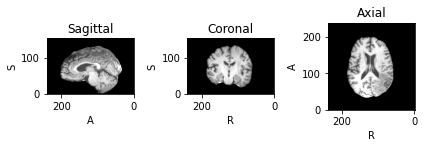

t2


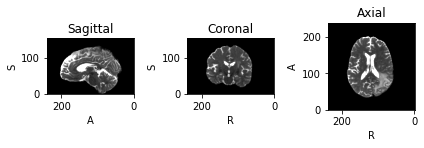

t1ce


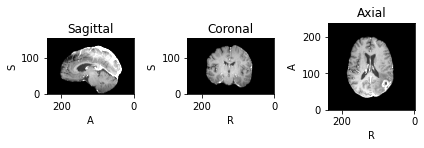

flair


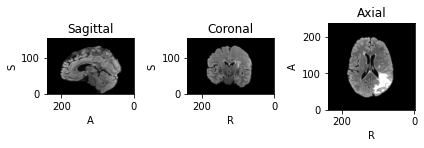

seg


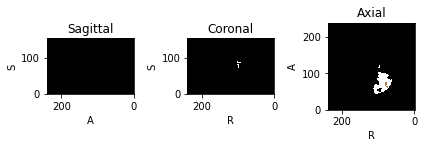

In [ ]:
# 시각화
for key in check_data.keys():
  print(key)
  if type(check_data[key]) is tio.data.image.ScalarImage or type(check_data[key]) is tio.data.image.LabelMap:
    check_data[key].plot()
  else:
    print(check_data[key])
  print('='*20)

In [ ]:
# 분포 확인
for key in check_data.keys():
  if type(check_data[key]) is tio.data.image.ScalarImage or type(check_data[key]) is tio.data.image.LabelMap:
    print(key)
    print(f'mean: {check_data[key].data.to(float).mean():.4f}')
    print(f'std: {check_data[key].data.to(float).std():.4f}')
    print(f'median: {check_data[key].data.median()}')
    print(f'range: [{check_data[key].data.min()},{check_data[key].data.max()}]')
    print('='*20)

t1
mean: 285.0955
std: 695.4845
median: 0
range: [0,5182]
t2
mean: 109.0438
std: 297.4236
median: 0
range: [0,2807]
t1ce
mean: 301.1295
std: 751.0920
median: 0
range: [0,10493]
flair
mean: 165.9517
std: 425.8480
median: 0
range: [0,3116]
seg
mean: 0.0253
std: 0.2467
median: 0
range: [0,4]


##### 2. Train-Validation-Test 데이터의 구분

In [ ]:
train_subject_list, test_subject_list = train_test_split(torchio_subject_list, test_size=0.05, shuffle=True, random_state=0)
train_subject_list, validation_subject_list = train_test_split(train_subject_list, test_size=0.1, shuffle=True, random_state=0)

In [ ]:
# test 데이터는 추후 활용 위해 따로 저장
for subject in test_subject_list:
  os.makedirs(os.path.join(DATADIR+'_test', subject['id']), exist_ok=True)
  copyfile(os.path.join(DATADIR, subject['id'], subject['id']+'_t1.nii.gz'), os.path.join(DATADIR+'_test', subject['id'], subject['id']+'_t1.nii.gz'))
  copyfile(os.path.join(DATADIR, subject['id'], subject['id']+'_t2.nii.gz'), os.path.join(DATADIR+'_test', subject['id'], subject['id']+'_t2.nii.gz'))
  copyfile(os.path.join(DATADIR, subject['id'], subject['id']+'_t1ce.nii.gz'), os.path.join(DATADIR+'_test', subject['id'], subject['id']+'_t1ce.nii.gz'))
  copyfile(os.path.join(DATADIR, subject['id'], subject['id']+'_flair.nii.gz'), os.path.join(DATADIR+'_test', subject['id'], subject['id']+'_flair.nii.gz'))

##### 3. tio.Subject 객체 리스트를 이용해 tio.SubjectsDataset 객체 만들기

In [ ]:
# 일괄 적용할 변환 (transform) 명시하기
transforms = [
  tio.ToCanonical(),
  tio.Resample(3),
  tio.CropOrPad((64,64,48)),
  tio.RescaleIntensity(out_min_max=(0, 1)),
]
transform = tio.Compose(transforms)

# SubjectsDataset 객체 만들기
train_dataset = tio.SubjectsDataset(train_subject_list, transform=transform)
validation_dataset = tio.SubjectsDataset(validation_subject_list, transform=transform)

###### 1. 데이터 확인해보기

In [ ]:
# 첫번째 데이터를 대표로 확인
check_data = train_dataset[0]

id
BraTS2021_00183
t1


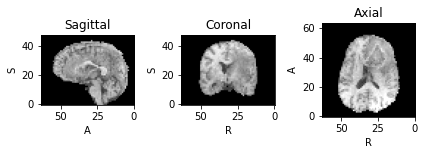

t2


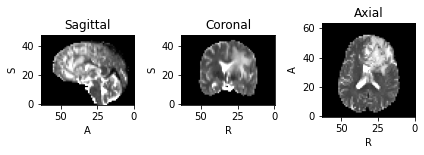

t1ce


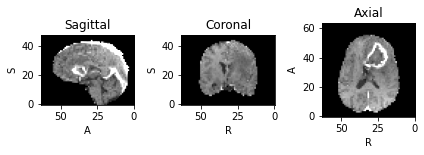

flair


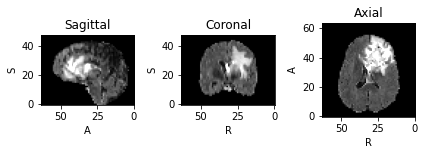

seg


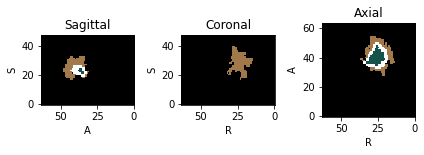

In [ ]:
# 시각화
for key in check_data.keys():
  if type(check_data[key]) is tio.data.image.ScalarImage or type(check_data[key]) is tio.data.image.LabelMap:
    print(key)
    check_data[key].plot()
  else:
    print(key)
    print(check_data[key])
  print('='*20)

In [ ]:
# 분포 확인
for key in check_data.keys():
  if type(check_data[key]) is tio.data.image.ScalarImage or type(check_data[key]) is tio.data.image.LabelMap:
    print(key)
    print(f'shape: {check_data[key].data.shape}')
    print(f'mean: {check_data[key].data.to(float).mean():.4f}')
    print(f'std: {check_data[key].data.to(float).std():.4f}')
    print(f'median: {check_data[key].data.median()}')
    print(f'range: [{check_data[key].data.min()},{check_data[key].data.max()}]')
    print('='*20)

t1
shape: torch.Size([1, 64, 64, 48])
mean: 0.1161
std: 0.2086
median: 0.0
range: [0.0,1.0]
t2
shape: torch.Size([1, 64, 64, 48])
mean: 0.0777
std: 0.1517
median: 0.0
range: [0.0,1.0]
t1ce
shape: torch.Size([1, 64, 64, 48])
mean: 0.0796
std: 0.1451
median: 0.0
range: [0.0,1.0]
flair
shape: torch.Size([1, 64, 64, 48])
mean: 0.0441
std: 0.0889
median: 0.0
range: [0.0,1.0]
seg
shape: torch.Size([1, 64, 64, 48])
mean: 0.0664
std: 0.4129
median: 0
range: [0,4]


### 3. 모델 준비하기

#### 1. 모델 객체 정의하기

In [ ]:
model = monai.networks.nets.BasicUNet(spatial_dims=3, in_channels=4, out_channels=2)

BasicUNet features: (32, 32, 64, 128, 256, 32).


##### U-Net이 무엇인가?

https://www.nature.com/articles/s41592-018-0261-2

#### 2. 모델 구조 확인해보기

In [ ]:
print(model)

BasicUNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (down_1): Down(
    (max_pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): TwoConv(
      (conv_0): Convolution(
        (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (adn): ADN(
 

### 4. 학습 준비하기

#### 1. 하이퍼파라미터 결정하기

In [ ]:
num_epochs = 30
batch_size = 32
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 2. 관련 함수 정의하기

###### 1. 학습 함수 구현

In [ ]:
def train_step(model, dataloader, criterion, optimizer, scheduler, device):
  model.train() # 모델에서 학습시와 추론시의 연산이 다른 구성들의 (예: Dropout, BatchNorm 등) 세팅을 맞춰줌
  model.to(device)
  
  # 데이터별 메트릭을 저장할 리스트 정의
  metric_loss = 0.0
  metric_dice = 0.0

  # 미니배치 단위로 데이터를 불러옴
  for data in tqdm(dataloader):
    input = torch.cat([data[sequence]['data'] for sequence in ['t1', 't2', 't1ce', 'flair']], dim=1).to(device)
    label = data['seg']['data'].squeeze(1).long().to(device)
    label[label!=0] = 1
    output = model(input)
    loss = criterion(output, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    pred = output.argmax(dim=1)

    metric_dice += float(monai.metrics.compute_meandice(
            torch.nn.functional.one_hot(pred.cpu().detach(), 2), 
            torch.nn.functional.one_hot(label.cpu().detach(), 2)).mean()) / len(dataloader)
    metric_loss += float(loss.cpu().detach()) / len(dataloader)
  
  scheduler.step()
  
  return metric_dice, metric_loss

###### 2. 추론 함수 구현

In [ ]:
def eval_step(model, dataloader, device):
  model.eval() # 모델에서 학습시와 추론시의 연산이 다른 구성들의 (예: Dropout, BatchNorm 등) 세팅을 맞춰줌
  model.to(device)

  # 데이터별 메트릭을 저장할 리스트 정의
  metric_loss = 0.0
  metric_dice = 0.0

  # 미니배치 단위로 데이터를 불러옴
  for data in dataloader:
    input = torch.cat([data[sequence]['data'] for sequence in ['t1', 't2', 't1ce', 'flair']], dim=1).to(device)
    label = data['seg']['data'].squeeze(1).long().to(device)
    label[label!=0] = 1
    output = model(input)
    loss = criterion(output, label)

    pred = output.argmax(dim=1)

    metric_dice += float(monai.metrics.compute_meandice(
            torch.nn.functional.one_hot(pred.cpu().detach(), 2), 
            torch.nn.functional.one_hot(label.cpu().detach(), 2)).mean()) / len(dataloader)
    metric_loss += float(loss.cpu().detach()) / len(dataloader)
  
  return metric_dice, metric_loss

##### 3. 세그멘테이션 예측 함수 구현

In [ ]:
def get_segmentation(model, data, device):
  model.eval()
  model.to(device)
  input = torch.cat([data[sequence]['data'].unsqueeze(0) for sequence in ['t1', 't2', 't1ce', 'flair']], dim=1).to(device) # .unsqueeze(0): minibatch 방향의 차원을 임시로 추가
  output = model(input).cpu().detach()
  pred = torch.nn.functional.one_hot(output.argmax(dim=1).squeeze(0)).permute(3,0,1,2) # .squeeze(0): minibatch 방향의 차원을 제거 / .permute(3,0,1,2): 차원의 순서 변경
  return tio.LabelMap(tensor=pred)

#### 3. torch.utils.data.DataLoader 정의하기

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, 1, shuffle=False, num_workers=2, pin_memory=True)

### 5. 학습 실행하기

#### 1. 성능 평가 지표를 저장할 리스트 정의

In [ ]:
train_dice_list = []
train_loss_list = []
validation_dice_list = []
validation_loss_list = []

#### 2. 학습 루프 실행

Epoch 0


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9278 | loss 0.3928
Validation: dice 0.9905 | loss 0.2351


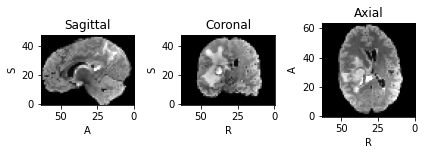

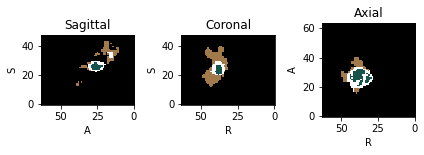

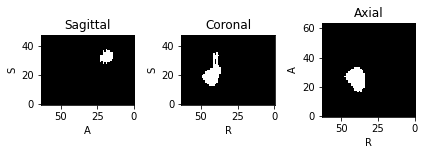

Epoch 1


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9922 | loss 0.1774
Validation: dice 0.9924 | loss 0.1313
Epoch 2


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9931 | loss 0.1052
Validation: dice 0.9925 | loss 0.0848
Epoch 3


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9939 | loss 0.0754
Validation: dice 0.9941 | loss 0.0679
Epoch 4


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9948 | loss 0.0618
Validation: dice 0.9947 | loss 0.0564
Epoch 5


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9951 | loss 0.0520
Validation: dice 0.9950 | loss 0.0484


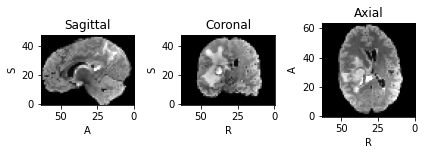

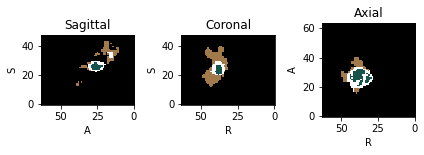

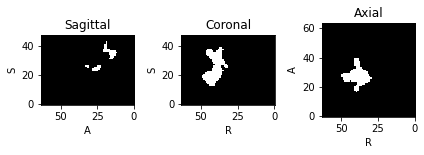

Epoch 6


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9954 | loss 0.0457
Validation: dice 0.9952 | loss 0.0442
Epoch 7


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9957 | loss 0.0421
Validation: dice 0.9955 | loss 0.0410
Epoch 8


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9958 | loss 0.0391
Validation: dice 0.9956 | loss 0.0382
Epoch 9


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9960 | loss 0.0367
Validation: dice 0.9957 | loss 0.0366
Epoch 10


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9961 | loss 0.0352
Validation: dice 0.9958 | loss 0.0352


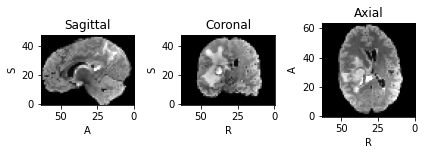

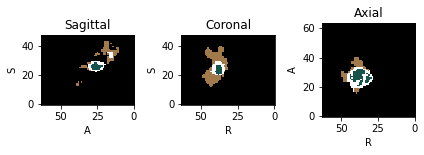

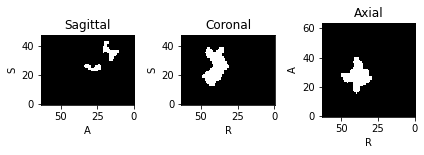

Epoch 11


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9961 | loss 0.0339
Validation: dice 0.9957 | loss 0.0341
Epoch 12


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9962 | loss 0.0330
Validation: dice 0.9959 | loss 0.0333
Epoch 13


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9963 | loss 0.0322
Validation: dice 0.9959 | loss 0.0327
Epoch 14


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9963 | loss 0.0316
Validation: dice 0.9958 | loss 0.0322
Epoch 15


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9964 | loss 0.0310
Validation: dice 0.9959 | loss 0.0318


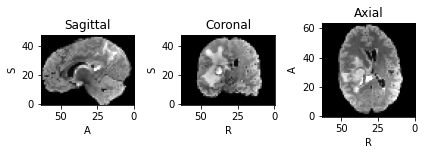

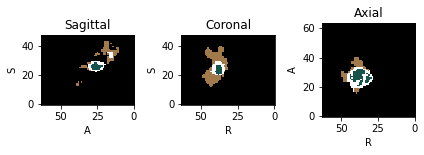

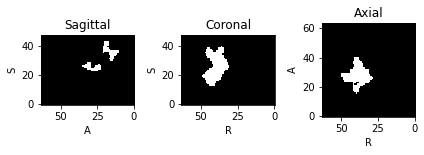

Epoch 16


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9964 | loss 0.0307
Validation: dice 0.9960 | loss 0.0314
Epoch 17


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9964 | loss 0.0304
Validation: dice 0.9960 | loss 0.0312
Epoch 18


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9964 | loss 0.0301
Validation: dice 0.9960 | loss 0.0310
Epoch 19


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9964 | loss 0.0299
Validation: dice 0.9961 | loss 0.0308
Epoch 20


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9965 | loss 0.0297
Validation: dice 0.9960 | loss 0.0306


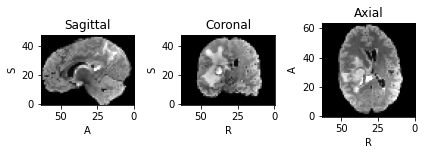

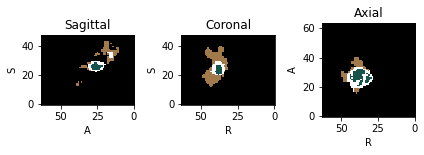

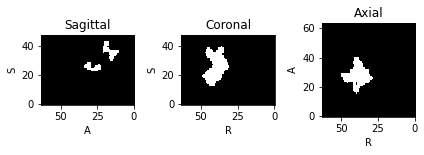

Epoch 21


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9965 | loss 0.0295
Validation: dice 0.9960 | loss 0.0306
Epoch 22


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9965 | loss 0.0295
Validation: dice 0.9960 | loss 0.0305
Epoch 23


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9965 | loss 0.0294
Validation: dice 0.9960 | loss 0.0304
Epoch 24


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9965 | loss 0.0293
Validation: dice 0.9961 | loss 0.0303
Epoch 25


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9965 | loss 0.0293
Validation: dice 0.9961 | loss 0.0303


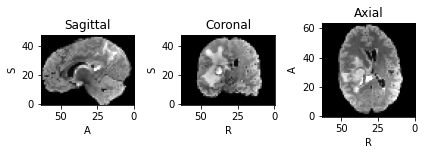

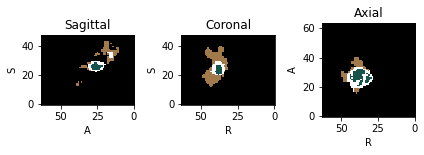

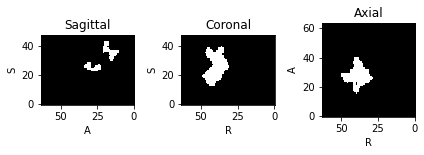

Epoch 26


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9965 | loss 0.0292
Validation: dice 0.9961 | loss 0.0302
Epoch 27


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9965 | loss 0.0291
Validation: dice 0.9961 | loss 0.0302
Epoch 28


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9965 | loss 0.0291
Validation: dice 0.9961 | loss 0.0302
Epoch 29


  0%|          | 0/34 [00:00<?, ?it/s]

Train: dice 0.9965 | loss 0.0291
Validation: dice 0.9961 | loss 0.0302


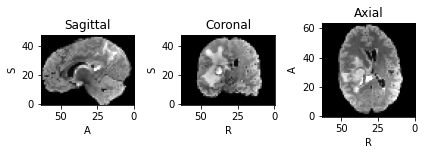

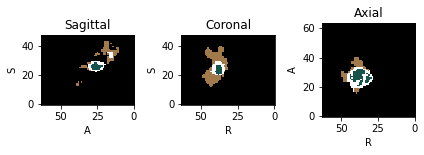

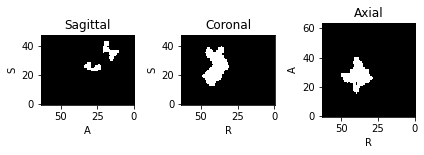

In [ ]:
for epoch in range(num_epochs):
  print(f'Epoch {epoch}')

  # Train 데이터로 1 Epoch 학습
  train_dice, train_loss = train_step(model, train_dataloader, criterion, optimizer, scheduler, device)

  # Validation 데이터로 성능 평가
  validation_dice, validation_loss = eval_step(model, validation_dataloader, device)

  # 현재 Epoch에서의 성능 지표 출력
  print(f'Train: dice {train_dice:.4f} | loss {train_loss:.4f}')
  print(f'Validation: dice {validation_dice:.4f} | loss {validation_loss:.4f}')

  # 현재 Epoch에서의 성능 지표를 리스트에 추가
  train_dice_list.append(train_dice)
  train_loss_list.append(train_loss)
  validation_dice_list.append(validation_dice)
  validation_loss_list.append(validation_loss)

  # 모델 저장
  torch.save(model.state_dict(), os.path.join(TARGETDIR, f'model_unet_epoch{epoch}.pth'))

  # 5 epoch마다 예시 결과를 시각화
  if epoch%5==0 or epoch==num_epochs-1:
    validation_dataset[0]['flair'].plot() # FLAIR 시각화
    validation_dataset[0]['seg'].plot() # 정답 세그멘테이션 시각화
    get_segmentation(model, validation_dataset[0], device).plot() # 예측된 세그멘테이션 시각화
  
  print('='*20)

#### 3. 학습 결과 시각화하기

##### 1. 성능 지표 그래프

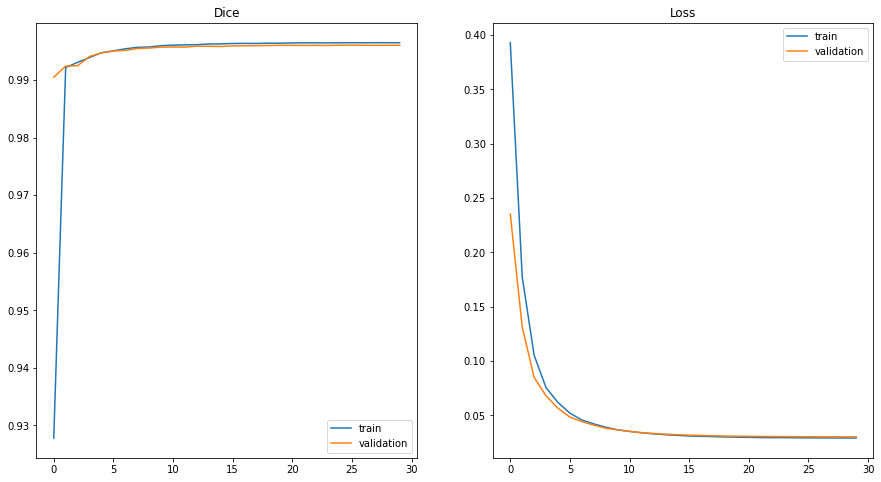

In [ ]:
%matplotlib inline

# 성능 지표 그래프 객체 정의
fig, ax = plt.subplots(figsize=(15,8), ncols=2)
ax[0].set_title('Dice')
ax[1].set_title('Loss')

# Epoch에 따른 성능 지표 향상 그래프 제시
ax[0].plot(list(range(len(train_dice_list))), train_dice_list, label='train')
ax[0].plot(list(range(len(validation_dice_list))), validation_dice_list, label='validation')
ax[0].legend()

ax[1].plot(list(range(len(train_loss_list))), train_loss_list, label='train')
ax[1].plot(list(range(len(validation_loss_list))), validation_loss_list, label='validation')
ax[1].legend()

##### 2. 예시 결과

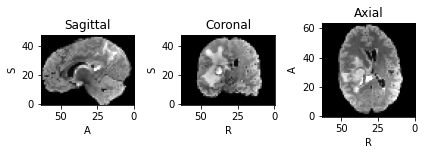

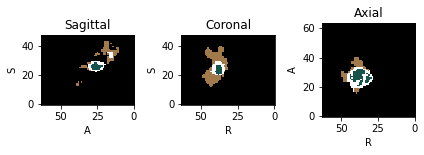

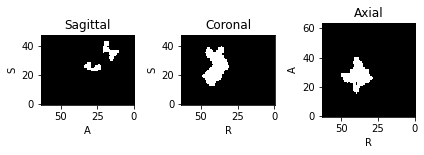

In [ ]:
# 예시 결과를 시각화
validation_dataset[0]['flair'].plot() # FLAIR 시각화
validation_dataset[0]['seg'].plot() # 정답 세그멘테이션 시각화
get_segmentation(model, validation_dataset[0], device).plot() # 예측된 세그멘테이션 시각화